# Lab 3. Principal Component Analysis

### Due date: Friday 02/11 at 10:59 pm


## Why dimension reduction?

A high-dimensional dataset, which contains a great number of features (or variables), presents many mathematical or computational challenges. The good news is that some variables are often correlated, that is, high-dimensional data are dominated “superficially” by a small number of simple variables. We can find a subset of the variables, either the original or linear combination of orginal variables, which contains the information of original dataset without losing too much information. Although high-power computing can somehow handle high-dimensional data, in many applications it is still necessary to reduce the dimensionality of the original data. As we have seen in Lab2, Lasso regression is one of the method to perform feature selection.


## Why PCA?

`Principal Component Analysis (PCA)` is probably the most popular technique when we think of dimension reduction. The idea of principal component analysis (PCA) is to reduce the dimensionality of a dataset consisting of a large number of related variables while retaining as much variance in the data as possible. PCA finds a set of new variables, which are linear combinations of the original variables, called `Principal Components (PCs)`. Principal components are orthogonal to each other. The intuition of PCA is shown in the following figure. it 'rotates' the axes to line up better with your data. The first principal component will capture most of the variance in the data, then followed by the second, third(if necessary), and so on. As a result the new data will have fewer dimensions.

![pca-2-dimensions](pca-2-dimensions.png)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
%matplotlib inline

In this Lab, we will walk through an example of using Principal Component Analysis (PCA) on a dataset involving [iris plants](https://en.wikipedia.org/wiki/Iris_(plant)).
Run the following cell to load the iris dataset into this notebook. 

* `iris_features` will contain a numpy array of 4 attributes for 150 different plants (shape 150 x 4). This is the matrix onto which we are going to apply PCA. To follow the lecture notes, we are going to traspose it to have shape 4x150. 
* `iris_target` will contain the class of each plant. There are 3 classes of plants in the dataset: Iris-Setosa, Iris-Versicolour, and Iris-Virginica. The class names will be stored in `iris_target_names`.
* `iris_feature_names` will be a list of 4 names, one for each attribute in `iris_features`. 

Additional information on the dataset will be included in the description printed at the end of the following cell.

In [2]:
iris_data = load_iris() # Loading the dataset

# Unpacking the data into arrays
iris_features = iris_data['data']
iris_target = iris_data['target']
iris_feature_names = iris_data['feature_names']
iris_target_names = iris_data['target_names']

# Convert iris_target to string labels instead of int labels currently (0, 1, 2) for the classes
iris_target = iris_target_names[iris_target]

#traspose iris_features to have shape m x n
iris_features = iris_features.T
print("Feature names:", iris_feature_names)
print("Feature shape:", iris_features.shape)
print("Target names:", iris_target_names)

Feature names: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Feature shape: (4, 150)
Target names: ['setosa' 'versicolor' 'virginica']


The features and target names of iris dataset are shown in the following figure.

![iris](iris.png)

Let's explore the data by creating a scatter matrix of our iris features. To do this, we'll create 2D scatter plots for every possible pair of our four features. This should result in six total scatter plots in our scatter matrix.

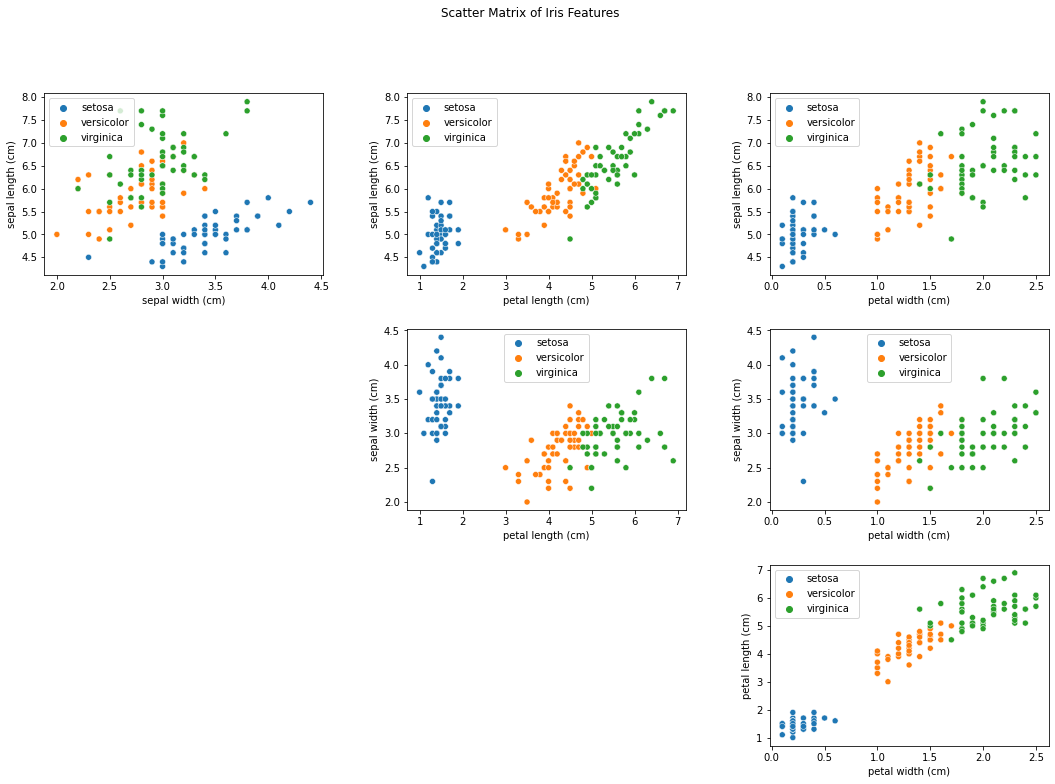

In [3]:
plt.figure(figsize=(18, 12))
plt.suptitle("Scatter Matrix of Iris Features")
plt.subplots_adjust(wspace=0.3, hspace=0.3)
for i in range(1, 4):
    for j in range(i):
        plt.subplot(3, 3, i+3*j)
        sns.scatterplot(x = iris_features[i,: ], y = iris_features[j, :], hue=iris_target)
        plt.xlabel(iris_feature_names[i])
        plt.ylabel(iris_feature_names[j])

## Goal of this Lab

The goal of this Lab is to find two `Principal Components (PCs)`, which contains most variance of orginal dataset, to classify the input data point as one of the three iris types. Mathematically, if we stack all the data points as column vectors of a matrix $X$(we assume $X$ being centered without loss of generality), the matrix should have (approximately) low-rank
$$
    X = L_0 + N_0.
$$
where $L_0$ has low-rank and $N_0$ is a small perturbation matrix. `Principal Component Analysis (PCA)` seeks the best rank-$k$ estimate of $L_0$ by solving
\begin{align*}
    \text{minimize } &\,\|X - L \|_{F}\\
    \text{subject to } &\, rank(L)\leq k\,.
\end{align*}

This problem can be efficiently solved via the `singular value decomposition (SVD)` and enjoys a number of optimality properties if the noise $N_0$ is small and i.i.d. Gaussian. We will go through this task step by step.

## Step 1. Standardization.

To apply PCA, we will first need to "center" the data so that the mean of each feature is 0. Compute the rowise mean of `iris_features` in the cell below and store it in `iris_mean` (should be a numpy array of $4$ means, 1 for each attribute). Then, subtract `iris_mean` from `iris_features` and save the result in `centered_features`. Compute the unbiased sample covariance matrix $C = XX^{T}/(n-1)$ and save it in `cov`, where $n$ is the number of samples in our dataset. 

**Hints:** 
* Use `np.mean` or `np.average` to compute `iris_mean`, and pay attention to the `axis` argument.
* If you are confused about how numpy deals with arithmetic operations between arrays of different shapes, see this note about [broadcasting](https://docs.scipy.org/doc/numpy/user/basics.broadcasting.html) for explanations/examples.

In [19]:
n = iris_features.shape[1] # should be n = 150
iris_mean = np.mean(iris_features, axis=1)
iris_mean.shape = (iris_mean.size, 1)

"""
TODO: 1. Center the iris_features and print covariance matrix 
"""

### BEGIN SOLUTION
centered_features = iris_features - iris_mean
cov = centered_features@centered_features.T/(n-1)
### END SOLUTION

print(np.mean(centered_features, axis=1)) # check the mean of each feature
print(cov)

[-1.12502600e-15 -7.60872846e-16 -2.55203266e-15 -4.48530102e-16]
[[ 0.68569351 -0.042434    1.27431544  0.51627069]
 [-0.042434    0.18997942 -0.32965638 -0.12163937]
 [ 1.27431544 -0.32965638  3.11627785  1.2956094 ]
 [ 0.51627069 -0.12163937  1.2956094   0.58100626]]


As you may recall from lecture, PCA is a specific application of the singular value decomposition (SVD) for matrices. In the following cell, let's use the [`np.linalg.svd`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.svd.html) function to compute the SVD of our `centered_features`. Store the left singular vectors, singular values, and right singular vectors in `U`, `S`, and `Vt` respectively.

**Hint:** Set the `full_matrices` argument of `np.linalg.svd` to `False`.

In [5]:
"""
TODO: 2. SVD of centered_features
"""

### BEGIN SOLUTION
U, S, Vt = np.linalg.svd(centered_features, full_matrices=False)
### END SOLUTION

print(U.shape)
print(S)
print(Vt.shape)

(4, 4)
[25.09996044  6.01314738  3.41368064  1.88452351]
(4, 150)


What can we learn from the singular values in `S`? First, the total variance of the data can be computed by summing the squared singular values and then scaling $1/(n-1)$, that is $\sum_{i=1}^{p}\sigma_i^2 /(n-1)$. We will later be able to use this value to determine the variance captured by a subset of our principal components.

In [6]:
"""
TODO: 3. Compute the total variance below and store the result in the variable `total_variance`.
"""

### BEGIN SOLUTION
total_variance = np.sum(np.square(S))/(n-1)
### END SOLUTION

print("total_variance = {:.3f} should approximately equal the sum of feature variances: {:.3f}"
      .format(total_variance, np.sum(np.var(iris_features, axis=1))))

total_variance = 4.573 should approximately equal the sum of feature variances: 4.542


## Step 2. Feature selection

Let's now use only the first two principal components to see what a 2D version of our iris data looks like.

In [7]:
"""
TODO: 4. Print the first two columns of U
"""
### BEGIN SOLUTION
print(U[:,[0, 1]])
### END SOLUTION

[[-0.36138659 -0.65658877]
 [ 0.08452251 -0.73016143]
 [-0.85667061  0.17337266]
 [-0.3582892   0.07548102]]


What is then the best 2-dimensional affine subspace? Here, to define an affine subspace, you need to specify the translation vector $\mu$ and the matrix $Q$ with as columns a basis for the subspace.

In [8]:
mu = iris_mean
Q = U[:,[0, 1]]

"""
TODO: 5. Find the rank-2 principal coordinates of the centered_features.
         Store the result in the variable `PCs_centered`
"""

### BEGIN SOLUTION
PCs_centered = Q.T@centered_features
### END SOLUTION

In [9]:
"""
TODO: 6. find the projection of iris_mean on the affine subspace
         store the result in the variable `PCs_mean`
"""
### BEGIN SOLUTION
PCs_mean = Q.T@iris_mean
### END SOLUTION

In [10]:
"""
TODO: 7. find the projection of iris_features
         store the result in the variable `PCs`
"""
### BEGIN SOLUTION
PCs = PCs_centered + PCs_mean
### END SOLUTION

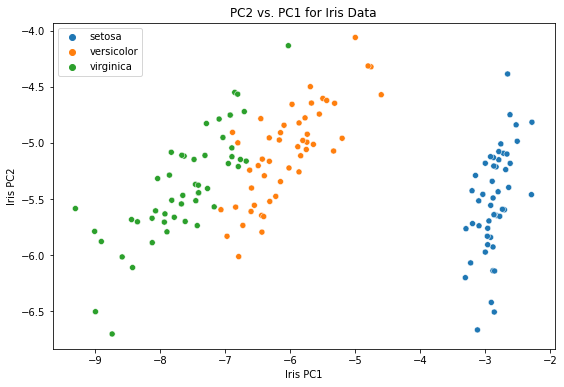

In [11]:
plt.figure(figsize=(9, 6))
plt.title("PC2 vs. PC1 for Iris Data")
plt.xlabel("Iris PC1")
plt.ylabel("Iris PC2")
sns.scatterplot(x = PCs[0, :], y = PCs[1, :], hue = iris_target);

As we can see from the plot, the setosa class is still separated from the other two classes, and there is some slight overlap between the other two classes. Perfect classification between the versicolor and verginica classes would be hard using this representation. 

What proportion of the total variance is accounted for when we project the iris data down to two dimensions? Compute this quantity in the cell below.

In [12]:
"""
TODO: 8. Compute the variance of the first two PCs and store the result in the variable `two_dim_variance`.
"""

### BEGIN SOLUTION
two_dim_variance = np.sum(np.square(S[:2])) / (n-1)
### END SOLUTION

print("The variance of first two components is ", two_dim_variance)
ratio = two_dim_variance / total_variance
print("The ratio two_dim_variance / total_variance = ", ratio)

The variance of first two components is  4.470912453963503
The ratio two_dim_variance / total_variance =  0.977685206318795


As we can see, the ratio two_dim_variance/total_variance is approximately $0.978$, that is, $97.8\%$ of the variance can be accounted by first two PCs.

Also, let's create a [scree plot](https://en.wikipedia.org/wiki/Scree_plot) to visualize the weight of each principal component. In the cell below, create a scree plot by plotting a line plot of the square of the singular values in `s` vs. the principal component number (1st, 2nd, 3rd, or 4th). As we may see, the first two accounts most variance.

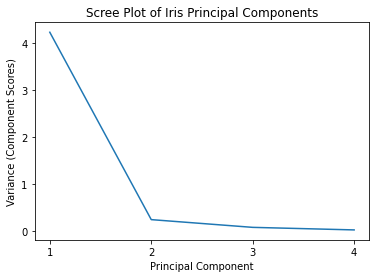

In [13]:
plt.xticks([1, 2, 3, 4])
plt.xlabel("Principal Component")
plt.ylabel("Variance (Component Scores)")
plt.title("Scree Plot of Iris Principal Components")
plt.plot([1, 2, 3, 4], np.square(S)/(n-1));

## Robust PCA (Optional)

#### References:  
* https://arxiv.org/pdf/0912.3599.pdf 
* https://github.com/dganguli/robust-pca 


PCA is arguably the most widely used statistical tool for data analysis and dimensionality reduction today. However, it is sensitive to outliers, that is, a single grossly corrupted entry in $X$ could render the estimated $\hat{L}$ arbitrarily far from the true $L_0$. Unfortunately, gross errors are now ubiquitous in modern applications such as image processing, web data analysis, and bioinformatics, where some measurements may be arbitrarily corrupted (due to occlusions, malicious tampering, or sensor failures) or simply irrelevant to the low-dimensional structure we seek to identify. The new problem we consider here can be considered as an idealized version of `Robust PCA`, in which we aim to recover a low-rank matrix $L_0$ from highly corrupted measurements $X = L_0+S_0$. Unlike the small noise term $N_0$ in `classical PCA`, the entries in $S_0$ can have arbitrarily large magnitude, and their support is assumed to be sparse but unknown. 

Mathematical, it can be solved by tractable convex optimization. Let $\|M\|_{*} = \sum_{i}\sigma_i(M)$ denote the nuclear norm of the matrix $M$, i.e. the sum of the singular values of $M$, and let $\|M\|_{1} = \sum_{ij}M_{ij}$ denote the $\ell^1$ norm of $M$. Then under rather weak assumptions, the `Principal Component Pursuit (PCP)` estimate solving
\begin{align*}
    \text{minimize } &\,\| L \|_{*} + \lambda \|S\|_{1}\\
    \text{subject to } &\, L + S = X\,
\end{align*}
exactly recovers the low-rank $L_0$ and the sparse $S_0$. Theoretically, this is guaranteed to work even if
the rank of $L_0$ grows almost linearly in the dimension of the matrix, and the errors in $S_0$ are up to a
constant fraction of all entries.

In [14]:
from r_pca import R_pca

# use R_pca to estimate the degraded data as L + S, where L is low rank, and S is sparse
rpca = R_pca(centered_features)
L, S = rpca.fit(max_iter=10000, iter_print=100)

iteration: 1, error: 0.06292791894640061
iteration: 100, error: 0.0001889877387281832
iteration: 200, error: 0.00030875537640028493
iteration: 300, error: 0.00015672695888824075
iteration: 400, error: 7.248362981058272e-05
iteration: 500, error: 6.191510110635895e-05
iteration: 600, error: 5.307793960403594e-05
iteration: 700, error: 3.1065343007148524e-05
iteration: 800, error: 5.394366446395098e-05
iteration: 900, error: 2.3602565890073914e-05
iteration: 1000, error: 3.826251990717057e-05
iteration: 1100, error: 5.293282385049609e-05
iteration: 1200, error: 8.2764773697572e-06
iteration: 1300, error: 7.122077917765948e-06
iteration: 1400, error: 7.262446081160659e-06
iteration: 1500, error: 5.8688003437968095e-06
iteration: 1600, error: 1.1431470336506866e-05
iteration: 1700, error: 4.451797005695013e-06
iteration: 1800, error: 4.18062279210484e-06
iteration: 1900, error: 4.038568100438274e-06
iteration: 2000, error: 3.736994708752766e-06
iteration: 2100, error: 3.637473495931617e-05

In [15]:
def pca(data, num_components=None):
    """Principal Components Analysis

    Parameters
    ----------
    data : `numpy.ndarray`
        numpy array of data to analyse
    num_components : `int`
        number of principal components to use

    Returns
    -------
    PCs : `numpy.ndarray`
        Principal components
    Sigma : `numpy.ndarray`
        Singular values
    U : `numpy.ndarray`
        Singular vectors
    """
    m, n = data.shape
    data_mean = np.mean(data, axis=1) 
    data_mean.shape = (data_mean.size, 1)
    
    centered_data = data - data_mean
    U, Sigma, Vt = np.linalg.svd(centered_data, full_matrices=False)    
    idx = np.argsort(Sigma)[::-1] # sort the singular values
    Sigma = Sigma[idx]
    U = U[:,idx]
    if num_components is not None:
        Q = U[:, :num_components]
    else:
        Q = U
    # carry out the transformation on the data using singular vectors
    # and return the PCs, singular values, and singular vectors
    PCs_centered = Q.T@centered_data
    PCs_mean = Q.T@data_mean
    PCs = PCs_centered + PCs_mean
    
    return PCs, Sigma, U

The singular values are
[2.03259937e+01 1.58792761e+00 4.48611842e-15 9.57698017e-16]
For robust PCA:
The total variance is  2.789715003753169
The variance of first two components is  2.789715003753169
The ratio two_dim_variance / total_variance =  1.0


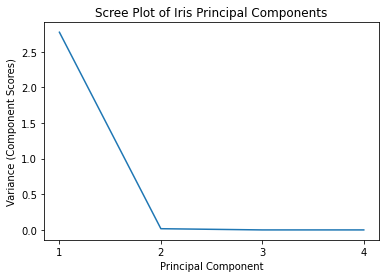

In [18]:
iris_rpca, Sigma_rpca, U_rpca = pca(L, num_components=2)

print("The singular values are")
print(Sigma_rpca)

total_variance_rpca = np.sum(np.square(Sigma_rpca))/(n-1)
two_dim_variance_rpca = np.sum(np.square(Sigma_rpca[:2]))/(n-1)
ratio_rpca = two_dim_variance_rpca / total_variance_rpca

print("For robust PCA:")
print("The total variance is ", total_variance_rpca)
print("The variance of first two components is ", two_dim_variance_rpca)
print("The ratio two_dim_variance / total_variance = ", ratio_rpca)

plt.xticks([1, 2, 3, 4])
plt.xlabel("Principal Component")
plt.ylabel("Variance (Component Scores)")
plt.title("Scree Plot of Iris Principal Components")
plt.plot([1, 2, 3, 4], np.square(Sigma_rpca)/(n-1));

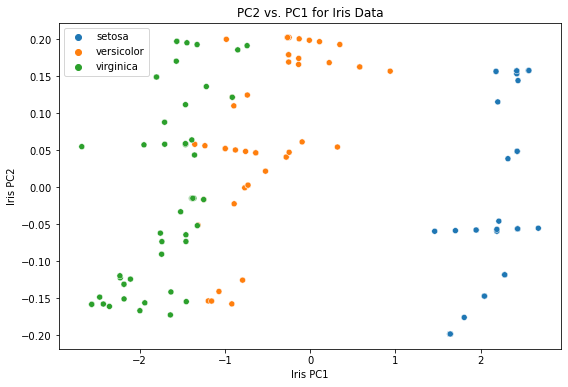

In [17]:
plt.figure(figsize=(9, 6))
plt.title("PC2 vs. PC1 for Iris Data")
plt.xlabel("Iris PC1")
plt.ylabel("Iris PC2")
sns.scatterplot(x = iris_rpca[0, :], y = iris_rpca[1, :], hue = iris_target);

As we can see, the ratio two_dim_variance/total_variance is $1.0$. Also from the plot, those three classes are approximately well separated from each other, and the overlaps between species are smaller than before. Therefore, the performance of robust PCA is better than classical PCA.

## Submission Instructions


### Download Code Portion
* Restart the kernel and run all the cells to make sure your code works.
* Save your notebook using File > Save and Checkpoint.
* Use File > Downland as > PDF via Latex.
* Download the PDF file and confirm that none of your work is missing or cut off. 
* **DO NOT** simply take pictures using your phone. 

### Submitting ###
* Submit the assignment to Lab1 on Gradescope. 
* **Make sure to assign only the pages with your implementation to the question.**